In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import ta
from ta import momentum, trend 
import numpy as np
import glob
import gc
import os
from tqdm import tqdm

## 🧠 ANFISClassifier: Neuro-Fuzzy Inference Model Implementation

This class implements a **zero-order Sugeno-type Adaptive Neuro-Fuzzy Inference System (ANFIS)** using PyTorch. The model is trained to predict stock trend strength based on technical indicators like RSI, MACD, and volume ratio.

### Key Components:

- `ANFISClassifier`: The main wrapper class for model training, prediction, and evaluation.
- `ANFISModel`: An inner class that defines the ANFIS network architecture as a subclass of `torch.nn.Module`.

### Model Architecture:

1. **Membership Functions (Layer 1)**:
   - Gaussian membership functions are defined by learnable parameters: centers and sigmas.
   - Each input feature has `num_mfs` membership functions.

2. **Rule Layer (Layer 2)**:
   - Forms fuzzy rules by computing combinations of membership degrees across inputs.
   - Firing strength of each rule is calculated via product (multiplication) of degrees.

3. **Normalization (Layer 3)**:
   - Normalizes firing strengths across all rules for each input instance.

4. **Output Layer (Layer 4–5)**:
   - Applies a **zero-order Sugeno model**, where each rule outputs a single constant (learnable parameter).
   - Final output is computed as the weighted average of rule outputs, using normalized firing strengths as weights.

### Training and Prediction:

- The model is trained using **binary cross-entropy loss** (`BCEWithLogitsLoss`) for binary classification.
- Predictions are made using a sigmoid threshold at 0.5.
- `predict_proba()` returns class probabilities.
- `score()` computes accuracy.

### Device Support:
- Automatically uses GPU if available, otherwise defaults to CPU.

This class provides a compact but powerful implementation of ANFIS suitable for binary classification tasks such as stock trend detection based on technical indicators.


In [2]:
class ANFISClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, num_mfs=2, epochs=50, lr=0.01, verbose=True):
        self.input_dim = input_dim
        self.num_mfs = num_mfs
        self.epochs = epochs
        self.lr = lr
        self.verbose = verbose
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None

    class ANFISModel(nn.Module):
        def __init__(self, input_dim, num_mfs):
            super().__init__()
            self.input_dim = input_dim
            self.num_mfs = num_mfs
            self.num_rules = num_mfs ** input_dim

            # Safer initialization
            self.centers = nn.Parameter(torch.rand(input_dim, num_mfs))
            self.sigmas = nn.Parameter(torch.rand(input_dim, num_mfs) * 0.5 + 0.5)  # values in [0.5, 1.0]

            # Rule consequents (zero-order Sugeno)
            self.rule_weights = nn.Parameter(torch.rand(self.num_rules))

        def gaussian(self, x, c, sigma):
            sigma = torch.clamp(sigma, min=1e-3)  # prevent division by zero
            return torch.exp(-0.5 * ((x - c) / sigma) ** 2)

        def forward(self, x):
            batch_size = x.size(0)
            mus = []

            # Step 1: Membership functions for each input
            for i in range(self.input_dim):
                xi = x[:, i].unsqueeze(1)
                ci = self.centers[i].unsqueeze(0)
                si = self.sigmas[i].unsqueeze(0)
                mu = self.gaussian(xi, ci, si)
                mus.append(mu)

            # Step 2: Compute rule firing strengths
            firing_strengths = mus[0]
            for i in range(1, self.input_dim):
                firing_strengths = firing_strengths.unsqueeze(2) * mus[i].unsqueeze(1)
                firing_strengths = firing_strengths.reshape(batch_size, -1)

            # Step 3: Normalize firing strengths
            w = firing_strengths
            epsilon = 1e-6
            w_sum = torch.sum(w, dim=1, keepdim=True) + epsilon
            w_normalized = w / w_sum

            # Step 4: Weighted output
            y_pred = torch.matmul(w_normalized, self.rule_weights)
            return y_pred

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        self.model = self.ANFISModel(self.input_dim, self.num_mfs).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.BCEWithLogitsLoss()

        for epoch in range(self.epochs):
            self.model.train()
            optimizer.zero_grad()
            y_logits = self.model(X_tensor)
            loss = loss_fn(y_logits, y_tensor)

            # Safety check
            if torch.isnan(loss):
                print("Loss became NaN. Training stopped.")
                break

            loss.backward()
            optimizer.step()

            if self.verbose and (epoch+1) % 10 == 0:
                preds = (torch.sigmoid(y_logits) > 0.5).float()
                acc = (preds == y_tensor).float().mean()
                print(f"Epoch {epoch+1}/{self.epochs} | Loss: {loss.item():.4f} | Acc: {acc.item():.4f}")

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            y_logits = self.model(X_tensor)
            y_pred = (torch.sigmoid(y_logits) > 0.5).cpu().numpy().astype(int)
        return y_pred

    def predict_proba(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            y_logits = self.model(X_tensor)
            probs = torch.sigmoid(y_logits).cpu().numpy()
        return np.stack([1 - probs, probs], axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

## Loading Stock Data

This section reads all CSV files from the specified folder containing historical stock data for NASDAQ-listed companies. Each file corresponds to a single stock and is stored in a dictionary (`stock_data`) using the stock ticker as the key.

For each file:
- Unnecessary columns (`Date`, `Open`, `High`, `Low`, `Close`) are dropped.
- Missing values are removed.
- A new feature `Daily_Return_%` is calculated as the percentage change in adjusted closing price.

In [6]:
# Path to the folder
folder_path = '/media/mahir_uddin/Mahir/5-2/Data Analytics/Projects/Stock Trend/Assignment Dataset/stocks'

# Get list of CSV files
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Load into dictionary
stock_data = {}

for file in tqdm(csv_files):
    try:
        ticker = os.path.basename(file).replace('.csv', '')
        df = pd.read_csv(file)
        df = df.drop(columns=['Date','Open','High','Low','Close'])
        df = df.dropna()
        df['Daily_Return_%'] = df['Adj Close'].pct_change(fill_method=None).fillna(0) * 100
        stock_data[ticker] = df   
        
        del df
        gc.collect()
        
    except Exception as e:
        print(f"Error loading {file}: {e}")


100%|███████████████████████████████████████| 5884/5884 [15:07<00:00,  6.48it/s]


## Adding Technical Indicators

This function `add_indicators()` processes each stock's DataFrame and appends selected technical indicators. The function supports computing the following indicators based on the `indicators` dictionary:

- **SMA**: Simple Moving Average for one or more window sizes
- **EMA**: Exponential Moving Average for specified periods
- **RSI**: Relative Strength Index (default window = 14)
- **MACD**: Moving Average Convergence Divergence and its signal line
- **Volume Ratio**: Ratio of short-term to long-term volume averages (e.g., 7-day to 21-day)

In [7]:
def add_indicators(stock_data, indicators):
    combined_df = []
    x = 0

    for ticker, df in stock_data.items():
        x += 1
        if x % 500 == 0:
            print(f"Processed {x} stocks...")

        df = df.copy()  # avoid modifying the original dictionary

        # --- SMA ---
        if 'SMA' in indicators:
            sma_periods = indicators.get('SMA', [14])
            if not isinstance(sma_periods, list):
                sma_periods = [sma_periods]
            for p in sma_periods:
                df[f'SMA_{p}'] = ta.trend.SMAIndicator(close=df['Adj Close'], window=p).sma_indicator()

        # --- EMA ---
        if 'EMA' in indicators:
            ema_periods = indicators.get('EMA', [14])
            if not isinstance(ema_periods, list):
                ema_periods = [ema_periods]
            for p in ema_periods:
                df[f'EMA_{p}'] = ta.trend.EMAIndicator(close=df['Adj Close'], window=p).ema_indicator()

        # --- RSI ---
        if 'RSI' in indicators:
            rsi_period = indicators.get('RSI', 14)
            df[f'RSI_{rsi_period}'] = ta.momentum.RSIIndicator(close=df['Adj Close'], window=rsi_period).rsi()

        # --- MACD ---
        if 'MACD' in indicators:
            macd_params = indicators.get('MACD', [12, 26, 9])
            macd = ta.trend.MACD(close=df['Adj Close'],
                                 window_fast=macd_params[0],
                                 window_slow=macd_params[1],
                                 window_sign=macd_params[2])
            df['MACD'] = macd.macd()
            df['MACD_Signal'] = macd.macd_signal()

        # --- Volume Ratio ---
        if 'Volume' in indicators:
            vol_params = indicators.get('Volume', [7, 21])
            short_avg = df['Volume'].rolling(window=vol_params[0]).mean()
            long_avg = df['Volume'].rolling(window=vol_params[1]).mean()
            df[f'Volume_Ratio_{vol_params[0]}_{vol_params[1]}'] = (short_avg / long_avg).replace([np.inf, -np.inf], np.nan)

        df = df.dropna()

        df.reset_index(drop=True, inplace=True)
        combined_df.append(df)

        del df
        gc.collect()

    return pd.concat(combined_df, ignore_index=True)


## Defining Indicators and Generating Target Variable

This section defines the list of technical indicators to extract from each stock's data:

- RSI with a 14-day window
- MACD with parameters [12, 26, 9]
- Volume Ratio using 7-day and 21-day moving averages

The `add_indicators()` function is called to compute these for all stocks and merge the results into a single DataFrame.

The target variable is generated as a binary label:
- 1 if the next day's adjusted close price is higher than the 5 day's before closing price,
- 0 otherwise.

This setup frames the task as a binary classification problem: predicting whether the stock will go up the next day.


In [8]:
# Define the indicators you want
indicators = {
    'RSI': 14,
    'MACD': [12, 26, 9],
    'Volume': [7, 21]
}

# Get one merged DataFrame from stock_data dictionary
stock_data = add_indicators(stock_data, indicators)

# Target column: 1 if next day's Adj Close is higher than 5 day's before closing price
stock_data['target'] = (stock_data['Adj Close'].shift(-1) > stock_data['Adj Close']).astype(int)
stock_data.dropna(inplace=True)

stock_data.head()

Processed 500 stocks...
Processed 1000 stocks...
Processed 1500 stocks...
Processed 2000 stocks...
Processed 2500 stocks...
Processed 3000 stocks...
Processed 3500 stocks...
Processed 4000 stocks...
Processed 4500 stocks...
Processed 5000 stocks...
Processed 5500 stocks...


,Adj Close,Volume,Daily_Return_%,RSI_14,MACD,MACD_Signal,Volume_Ratio_7_21,target
0,23.476856,1665200.0,-4.500763,31.231522,-0.509059,-0.478854,0.746194,0
1,23.337391,1687700.0,-0.594055,30.417620,-0.595366,-0.502156,0.818538,0
2,23.263008,1494700.0,-0.318728,29.969037,-0.662135,-0.534152,0.847824,1
3,23.941746,1993600.0,2.917669,38.833373,-0.652756,-0.557873,0.887167,1
4,24.034719,1945900.0,0.388333,39.954562,-0.630553,-0.572409,0.884875,1


## Feature Selection and Train-Test Split

The selected input features for the ANFIS model are:

- `RSI_14` – Relative Strength Index
- `MACD` – Moving Average Convergence Divergence
- `Volume_Ratio_7_21` – Ratio of short-term to long-term volume averages

These features are extracted from the processed DataFrame and stored in `X`, while the target labels are stored in `y`.

A train-test split is performed with 80% of the data used for training and 20% for testing. Shuffling is disabled (`shuffle=False`) to preserve the temporal order of stock data, which is important in time-series prediction tasks.

In [9]:
features = ['RSI_14', 'MACD', 'Volume_Ratio_7_21']
X = stock_data[features].values
y = stock_data['target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

## Training and Evaluating the ANFIS Model

The `ANFISClassifier` is instantiated with the following configuration:

- `input_dim`: Number of input features (3 in this case)
- `num_mfs`: Number of membership functions per input (set to 3)
- `epochs`: Number of training iterations (50)
- `lr`: Learning rate (0.01)

The model is trained on the training set using binary cross-entropy loss and evaluated on the test set using accuracy. The final accuracy score provides an estimate of how well the ANFIS model generalizes to unseen data.

In [10]:
# Instantiate and train ANFIS classifier
model = ANFISClassifier(input_dim=len(features), num_mfs=3, epochs=50, lr=0.01)
model.fit(X_train, y_train)

# Evaluate
accuracy = model.score(X_test, y_test)
print(f"ANFIS Test Accuracy: {accuracy:.4f}")

Epoch 10/50 | Loss: 0.6934 | Acc: 0.5545
Epoch 20/50 | Loss: 0.6933 | Acc: 0.5546
Epoch 30/50 | Loss: 0.6932 | Acc: 0.5547
Epoch 40/50 | Loss: 0.6932 | Acc: 0.5549
Epoch 50/50 | Loss: 0.6931 | Acc: 0.5555
ANFIS Test Accuracy: 0.5587


### 📊 Result Interpretation

The ANFIS model achieved an accuracy of **55.87%** in predicting stock price movement using the selected indicators: **RSI**, **MACD**, and **Volume Ratio (7/21)**.

Although this performance is slightly better than random guessing, it indicates that there is room for improvement.

**Future Work:**
- Experiment with additional or alternative technical indicators
- Try different combinations of input features
- Modify the target variable to represent longer-term trends (e.g., 3-day or 5-day future movement)

These improvements may help the model learn more meaningful patterns and boost its predictive performance.

## Displaying Learned Fuzzy Rules

This function extracts and prints the fuzzy rules learned by the trained ANFIS model. 

- It retrieves the number of inputs, membership functions, and rule weights from the model parameters.
- It generates all possible combinations of membership functions (MFs) across inputs, representing the fuzzy rule antecedents.
- For each rule, it prints a human-readable statement in the form:

  `IF <feature1> IS <MF1> AND <feature2> IS <MF2> ... THEN output = <rule_weight>`

This helps interpret the model by showing how different fuzzy input conditions contribute to the output.

In [11]:
def print_learned_rules(model, feature_names=None):
    anfis_model = model.model
    input_dim = anfis_model.input_dim
    num_mfs = anfis_model.num_mfs
    rule_weights = anfis_model.rule_weights.detach().cpu().numpy()
    centers = anfis_model.centers.detach().cpu().numpy()
    sigmas = anfis_model.sigmas.detach().cpu().numpy()

    if feature_names is None:
        feature_names = [f"x{i+1}" for i in range(input_dim)]

    from itertools import product
    mf_labels = [f"MF{j+1}" for j in range(num_mfs)]
    mf_combos = list(product(mf_labels, repeat=input_dim))

    for i, combo in enumerate(mf_combos):
        rule = " AND ".join([
            f"{feature_names[j]} IS {combo[j]}"
            for j in range(input_dim)
        ])
        print(f"Rule {i+1}: IF {rule} THEN output = {rule_weights[i]:.4f}")


## Displaying Rule Firing Strengths for a Sample Input

This function computes and prints the normalized firing strengths of all fuzzy rules for a given input sample. It helps understand which rules are most active for that particular input.

In [15]:
def show_rule_strengths(model, x_sample):
    anfis_model = model.model
    anfis_model.eval()
    x_tensor = torch.tensor(x_sample.reshape(1, -1), dtype=torch.float32).to(model.device)
    with torch.no_grad():
        # Step-by-step: Get rule firing strengths
        batch_size = x_tensor.size(0)
        mus = []
        for i in range(anfis_model.input_dim):
            xi = x_tensor[:, i].unsqueeze(1)
            ci = anfis_model.centers[i].unsqueeze(0)
            si = anfis_model.sigmas[i].unsqueeze(0)
            mu = anfis_model.gaussian(xi, ci, si)
            mus.append(mu)

        firing_strengths = mus[0]
        for i in range(1, anfis_model.input_dim):
            firing_strengths = firing_strengths.unsqueeze(2) * mus[i].unsqueeze(1)
            firing_strengths = firing_strengths.reshape(batch_size, -1)

        norm_strengths = firing_strengths / torch.sum(firing_strengths, dim=1, keepdim=True)
        norm_strengths = norm_strengths.cpu().numpy()[0]

    print("Rule strengths:")
    for i, strength in enumerate(norm_strengths):
        print(f"Rule {i+1}: {strength:.4f}")


## Plotting Membership Functions (MFs)

This function visualizes the learned Gaussian membership functions for each input feature. 

For each feature, it plots all membership functions using their current centers and sigmas, showing how input values map to degrees of membership.

In [12]:
def plot_mfs(model, feature_names=None, resolution=300):
    anfis_model = model.model
    centers = anfis_model.centers.detach().cpu().numpy()
    sigmas = anfis_model.sigmas.detach().cpu().numpy()
    input_dim = anfis_model.input_dim
    num_mfs = anfis_model.num_mfs

    if feature_names is None:
        feature_names = [f"Feature {i+1}" for i in range(input_dim)]

    fig, axs = plt.subplots(1, input_dim, figsize=(5 * input_dim, 4))

    for i in range(input_dim):
        c = centers[i]
        s = sigmas[i]

        # Estimate input range
        x_min = c.min() - 3 * s.max()
        x_max = c.max() + 3 * s.max()
        x = np.linspace(x_min, x_max, resolution)

        for j in range(num_mfs):
            y = np.exp(-0.5 * ((x - c[j]) / s[j]) ** 2)
            axs[i].plot(x, y, label=f"MF{j+1} (c={c[j]:.2f}, σ={s[j]:.2f})")

        axs[i].set_title(f"Membership Functions for {feature_names[i]}")
        axs[i].set_xlabel("Input value")
        axs[i].set_ylabel("Degree of membership")
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

### 🧠 Learned Fuzzy Rules

Below are the fuzzy rules learned by the ANFIS model during training. Each rule represents a combination of membership functions across the input indicators and their associated output strength. These rules form the core of the model’s decision-making process.

In [13]:
print_learned_rules(model, feature_names=["RSI", "MACD", "EMA"])

Rule 1: IF RSI IS MF1 AND MACD IS MF1 AND EMA IS MF1 THEN output = -0.0047
Rule 2: IF RSI IS MF1 AND MACD IS MF1 AND EMA IS MF2 THEN output = 0.3301
Rule 3: IF RSI IS MF1 AND MACD IS MF1 AND EMA IS MF3 THEN output = -0.1978
Rule 4: IF RSI IS MF1 AND MACD IS MF2 AND EMA IS MF1 THEN output = -0.4624
Rule 5: IF RSI IS MF1 AND MACD IS MF2 AND EMA IS MF2 THEN output = 0.2727
Rule 6: IF RSI IS MF1 AND MACD IS MF2 AND EMA IS MF3 THEN output = 0.4569
Rule 7: IF RSI IS MF1 AND MACD IS MF3 AND EMA IS MF1 THEN output = 0.4632
Rule 8: IF RSI IS MF1 AND MACD IS MF3 AND EMA IS MF2 THEN output = 0.0270
Rule 9: IF RSI IS MF1 AND MACD IS MF3 AND EMA IS MF3 THEN output = 0.3589
Rule 10: IF RSI IS MF2 AND MACD IS MF1 AND EMA IS MF1 THEN output = 0.1815
Rule 11: IF RSI IS MF2 AND MACD IS MF1 AND EMA IS MF2 THEN output = -0.2627
Rule 12: IF RSI IS MF2 AND MACD IS MF1 AND EMA IS MF3 THEN output = 0.1347
Rule 13: IF RSI IS MF2 AND MACD IS MF2 AND EMA IS MF1 THEN output = -0.2606
Rule 14: IF RSI IS MF2 AND MA

### 📉 Learned Membership Functions

Below are the membership functions (MFs) learned by the ANFIS model for each input variable. These functions define how the input values are fuzzified and play a crucial role in shaping the fuzzy rules.

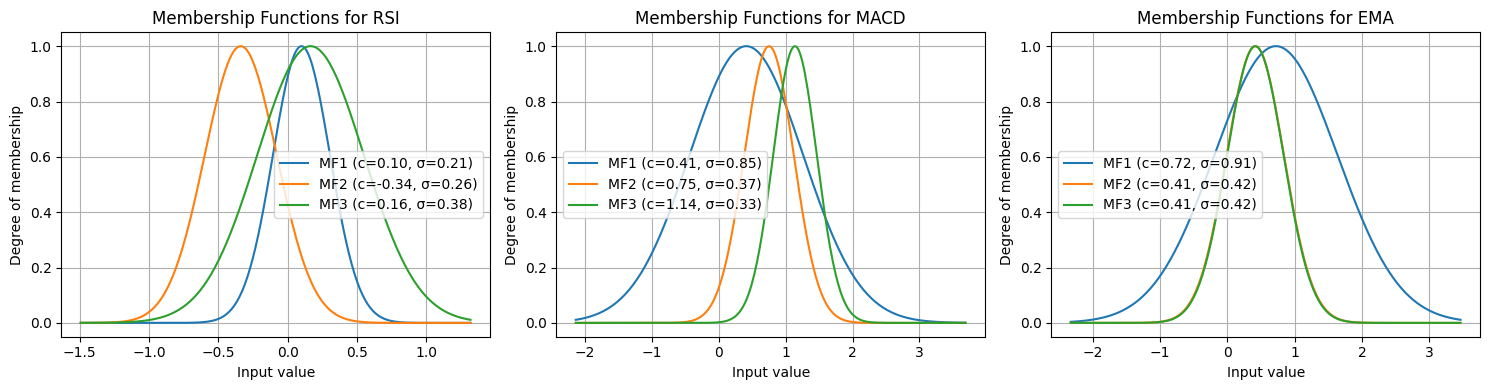

In [14]:
plot_mfs(model, feature_names=["RSI", "MACD", "EMA"])

### ✅ Conclusion

This project demonstrated how ANFIS (Adaptive Neuro-Fuzzy Inference System) can be applied to predict stock market trends using technical indicators like RSI, MACD, and Volume Ratio. The model achieved a test accuracy of **55.87%**, indicating some predictive capability.

While the performance is modest, it validates the potential of fuzzy-rule-based learning in financial forecasting. Future improvements such as incorporating additional indicators, tuning membership functions, or redefining the prediction target could further enhance accuracy.

This notebook also visualized the learned fuzzy rules and membership functions, giving insights into how the model reasons with stock data.
